## Bayesian Optimisation Verification

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy import stats
from scipy.stats import norm
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
from scipy.optimize import fsolve
import math

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Trial on TiOx/SiOx
Tempeature vs. S10_HF

In [2]:
#import timestamp from data sheet (time:0~5000s) 
address = 'data/degradation.xlsx'
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [0],names = None,nrows = 5000)
df_time = df.values.tolist()

In [3]:
#import data sheet at 85 C (time:0~5000s) 

df = pd.read_excel(address,sheet_name = 'normal data',usecols = [3],names = None,nrows = 5000)
df_85 = df.values.tolist() 
df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [3],names = None,nrows = 5000)
df_85s = df.values.tolist()

In [4]:
# Format date into numpy array format
x_normal = np.array(df_time).T
y_normal = np.array(df_85).T 
x_normal = x_normal.reshape((5000))
y_normal = y_normal.reshape((5000))
X_ = np.linspace(0,5000, 5000)

x_7_5000 = np.array([0,99,999,1999,2999,3999,4999])

In [5]:
# Plot function
def plot (x_normal ,y_normal, X,X_,y_mean,Y,y_cov):
    #plot function
    plt.figure()
    plt.plot(X_, y_mean, 'k', lw=1, zorder=4)
    plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),y_mean + np.sqrt(np.diag(y_cov)),alpha=0.5, color='k')
    # plt.scatter(X[:, 0], Y, c='r', s=1, zorder=3)
    plt.plot(x_normal, y_normal, 'c', lw=1, zorder=2)
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.title('Original')
    plt.xlim(0,4900)
    plt.ylim(0.7,0.8)
    plt.tight_layout()
    plt.show()

Length scale bound max = 10
Average absolute error: 3.73996e-01
Average percentage error: 50.1306 %


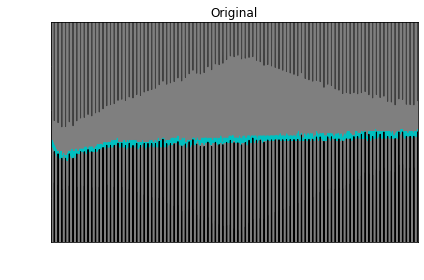

Length scale bound max = 20
Average absolute error: 6.18057e-02
Average percentage error: 8.2832 %


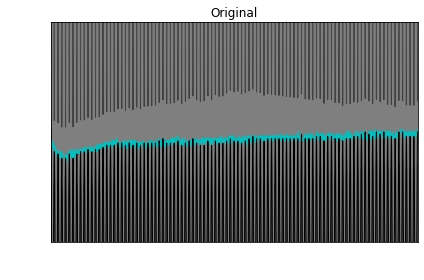

Length scale bound max = 50
Average absolute error: 2.90558e-03
Average percentage error: 0.3889 %


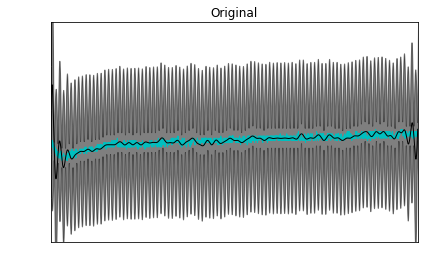

Length scale bound max = 100
Average absolute error: 1.0608e-03
Average percentage error: 0.1421 %


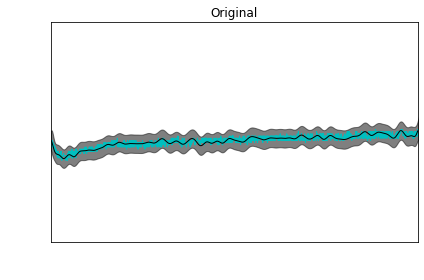

Length scale bound max = 200
Average absolute error: 8.45621e-04
Average percentage error: 0.1133 %


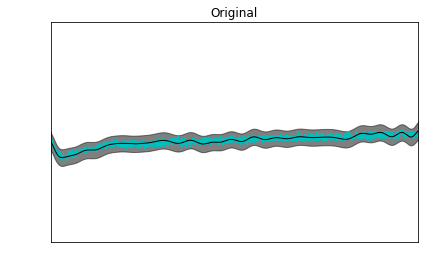

Length scale bound max = 400
Average absolute error: 7.58718e-04
Average percentage error: 0.1017 %


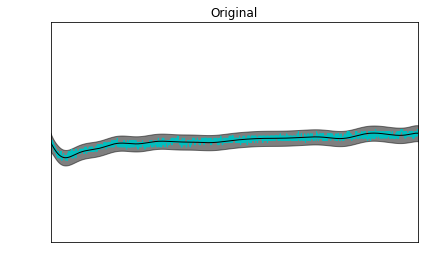

Length scale bound max = 500
Average absolute error: 7.63566e-04
Average percentage error: 0.1024 %


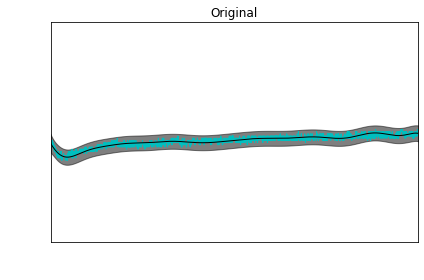

Length scale bound max = 700
Average absolute error: 7.76255e-04
Average percentage error: 0.1041 %


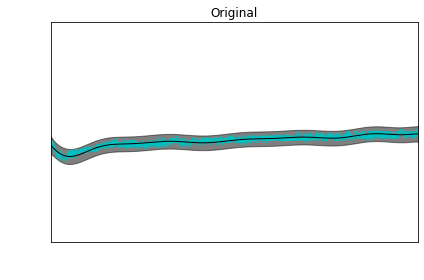

Length scale bound max = 1000
Average absolute error: 7.75486e-04
Average percentage error: 0.104 %


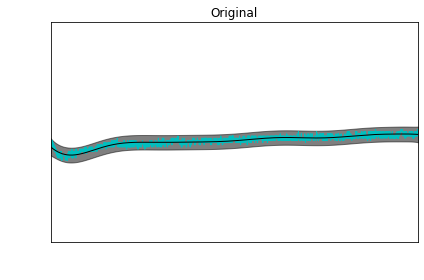

Length scale bound max = 1500
Average absolute error: 8.29154e-04
Average percentage error: 0.1112 %


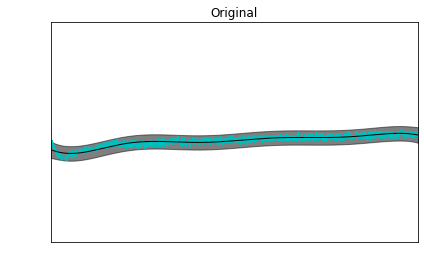

Length scale bound max = 2000
Average absolute error: 8.13859e-04
Average percentage error: 0.1091 %


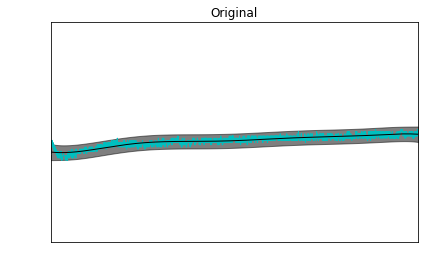

In [6]:
# Preparing training set from a few data points
NUM_OF_DATA_POINTS = 100
x_loop = np.arange(0,5000,int(5000/NUM_OF_DATA_POINTS))
X = x_loop
Y = y_normal[x_loop]
X = X.reshape(x_loop.size,1)


# Kernel setting
length_scale_bounds_MAX = None
length_scale_bounds_MIN = 1e-4

for length_scale_bounds_MAX in (10,20,50,100,200,400,500,700,1000,1500,2000):
    kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.0001)
    gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)
    y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
    print('Length scale bound max =',length_scale_bounds_MAX)
    print ('Average absolute error:',
    np.format_float_scientific(np.mean(np.absolute(y_normal-y_mean)),precision=5))
    print ('Average percentage error:',
    np.format_float_positional(np.mean(np.absolute((y_normal-y_mean)/y_normal*100)),precision=4),'%')
    plot(x_normal ,y_normal, X,X_,y_mean,Y,y_cov)

In [11]:
# Find the minimum value in the bound
# 5000 * 5000
# Find minimum value in the last row as the minimum value for the bound

def ucb(X , gp, dim, delta):
        """
        Calculates the GP-UCB acquisition function values
        Inputs: gp: The Gaussian process, also contains all data
        x:The point at which to evaluate the acquisition function 
        Output: acq_value: The value of the aquisition function at point x
        """
#     mean, var = gp.predict(X[:, np.newaxis], return_cov=True)
#     mean = np.atleast_2d(mean).T
#     var = np.atleast_2d(var).T  
#     beta = 2*np.log(np.power(5000,2.1)*np.square(math.pi)/(3*delta))
#     return mean - np.sqrt(beta)* np.sqrt(np.diag(var))
        y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
        return y_mean - np.sqrt(np.diag(y_cov))


Number of data points used: 20
Length scale bound max = 400
Average absolute error: 6.00136e-01
Average percentage error: 80.4438 %


ValueError: x and y must have same first dimension, but have shapes (5000,) and (1,)

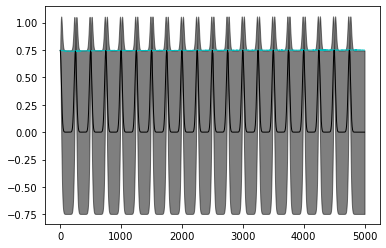

In [12]:
# Preparing training set from a range of data points
# Kernel setting
length_scale_bounds_MAX = 400
length_scale_bounds_MIN = 1e-4

for NUM_OF_DATA_POINTS in (20,30,40,50,60,80,100,120,150,200,300,500):
    x_loop = np.arange(0,5000,int(5000/NUM_OF_DATA_POINTS))
    X = x_normal[x_loop].reshape(x_loop.size)
    Y = y_normal[x_loop]
    X = X.reshape(x_loop.size,1)
    
    kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.00000001)
    gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)
    y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)

    # Get ucb prediction
    acp_value = ucb(X_, gp, 0.1, 5)
    # X_min = np.argmin(acp_value[-1])
    # ucb_y_min = acp_value[-1]

    print('Number of data points used:', x_loop.size)
    print('Length scale bound max =',length_scale_bounds_MAX)
    print ('Average absolute error:',
    np.format_float_scientific(np.mean(np.absolute(y_normal-y_mean)),precision=5))
    print ('Average percentage error:',
    np.format_float_positional(np.mean(np.absolute((y_normal-y_mean)/y_normal*100)),precision=4),'%')
    
    #plot function
    plt.figure()
    plt.plot(X_, y_mean, 'k', lw=1, zorder=4)
    plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),y_mean + np.sqrt(np.diag(y_cov)),alpha=0.5, color='k')
    plt.plot(x_normal, y_normal, 'c', lw=1, zorder=2)
    # plt.plot(x_normal,ucb_y_min,'pink',lw=1,zorder=5)
    # plt.scatter(np.argmin(ucb_y_min), min(ucb_y_min), c='r', s=20, zorder=6)
    plt.plot(x_normal,acp_value,'pink',lw=1,zorder=5)

    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.title('Original')
    # plt.xlim(0,4900)
    # plt.ylim(0.7,0.8)
    plt.tight_layout()
    plt.show()